You own a bike store. During week $t$, the (random) demand is $D_t$ units. 
On Monday morning you may choose to command $A_t$ additional units: they are delivered immediately before the shop opens. For each week:

  * Maintenance cost: $h$ per unit in stock left from the previous week (no maintenance is needed for newly commanded items)
  * Command cost: $c$ for each unit ordered + $c_0$ per command
  * Sales profit: $p$ per unit sold
  * Constraint: 
    - your warehouse has a maximal capacity of $M$ unit (any additionnal bike gets stolen)
    - you cannot sell bikes that you don't have in stock


* State: number of bikes in stock left from the last week => state space $\mathcal{S} = \{0,\dots, M\}$
* Action: number of bikes commanded at the beginning of the week => action space $\mathcal{A} = \{0, \dots ,M\}$ 
* Reward = balance of the week: if you command $a_t$ bikes,
$$r_t = -c_0 \mathbb{1}_{(a_t >0)}- c \times a_t - h\times s_t + p \times \min(D_t, s_t+a_t, M)$$
* Transitions: you end the week with the number of bikes $$s_{t+1} = \max\big(0, \min(M, s_t + a_t)  - D_t \big)$$ 

Our goal is to maximize the discounted sum of rewards, starting from an initial stock $s_1$, that is to find a policy whose value is 
$$V^*(s_1) = \max_{\pi}\mathbb{E}_{\pi}\left[\sum_{s=1}^{\infty} \gamma^{s-1}r_s \right].$$

In [1]:
import numpy as np
import random as rd
import gym
from matplotlib import pyplot as plt
import time 

### Problem parameters 

In [2]:
M = 15 # stock capacity
h = 0.3 # maintenance cost (per unit)
c = 0.5 # ordering cost (per unit)
c0 = 0.3 # fix delivery cost per command
p = 1 # selling price (per unit)

### Specifying the demand distribution 

We choose a (truncated) geometric distribution, for which 
$$\mathbb{P}(D_t = m) = q(1-q)^m \ \ \forall m \in \{0,\dots,M-1\}$$
and $\mathbb{P}(D_t = M) = 1 - \sum_{m=0}^{M-1}\mathbb{P}(D_t = m)$. 

In [3]:
# demand distribution (truncated geometric with parameter q)
q = 0.1
pdem = np.array([q*(1-q)**m for m in range(M+1)])
pdem[M] = pdem[M]+1-np.sum(pdem)

print("the average demand is ",np.sum([m*pdem[m] for m in range(M+1)]))

def SimuDemand(pdem): 
    cpdem = np.cumsum(pdem)
    i=0
    u = rd.random()
    while (u >cpdem[i]):
        i = i+1
    return i 

print("a simulated demand is ",SimuDemand(pdem))

the average demand is  7.1469798111481575
a simulated demand is  6


### Encoding of the MDP as a gym environment

This is just to give an example on how gym works. 

In [4]:
def nextstate(s,a,d,M):
    # computes the next state if the demand is d
    return max(0,min(M,s+a) -d)

def nextreward(s,a,d,M,c,c0,h,p):
    # computes the reward if the demand is d
    rew = -c*a - h*s + p*min(M,d,s+a)
    if (a>0):
        rew = rew - c0
    return rew

class StoreManagement(gym.Env):
    """
    Retail Store Management environment
    The environment defines which actions can be taken at which point and
    when the agent receives which reward.
    """
    def __init__(self,FirstState):
        
        # General variables defining the environment
        self.Stock_Capacity = M
        self.Maintenance_Cost = h
        self.Order_Cost = c 
        self.Delivery_Cost = c0
        self.Selling_Price = p
        self.Demand_Distribution = pdem
        
        # Define the action space
        self.action_space = gym.spaces.Discrete(self.Stock_Capacity+1)

        # Define the state space (state space = observation space in this example)
        self.observation_space = gym.spaces.Discrete(self.Stock_Capacity+1)

        # current time step
        self.curr_step = -1 # 
        
        # initial state
        self.state = FirstState

    def step(self, action):
        """
        simulates a transition following an action in the current state
        action : int
        """
        self.curr_step += 1
        # simulate the demand 
        Demand = SimuDemand(self.Demand_Distribution)
        # compute the reward
        reward = nextreward(self.state,action,Demand,self.Stock_Capacity,self.Order_Cost,self.Delivery_Cost,self.Maintenance_Cost,self.Selling_Price)
        # compute the next state 
        self.state = nextstate(self.state,action,Demand,self.Stock_Capacity)
        # return 4 elements: observation / reward / termination? (no terminal state here) / information (optional) 
        return self.state, reward, False, {}

    def reset(self,InitialStock):
        """
        Reset the state of the environment and returns an initial observation.
        """
        self.curr_step = -1
        self.state = InitialStock
    
    def _render(self, mode='human'):
        """optional visualization of the interaction: none here"""
        return


### A function that simulates a trajectory under a policy Pi starting from some state $s_0$

In [5]:
def SimulateTrajectory(T,Pi,s0):
    """return a vector of T successive states and a vector of T successive rewards"""
    Rewards = np.zeros(T+1)
    States = np.zeros(T+1)
    env=StoreManagement(s0)
    for t in range(T):
        States[t]=env.state
        action=Pi(env.state)
        state,rew,x,y=env.step(action)
        Rewards[t]=rew
    return States,Rewards

### Running simulations with three simple baselines 

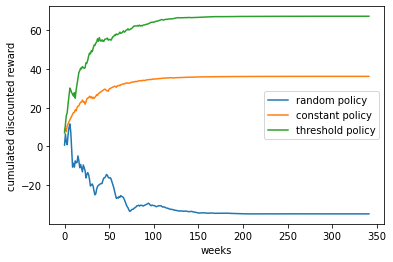

In [6]:
s1 = 10 # initial stock 
gamma = 0.97 # discount factor 

def PiUniform(s):
    # pick uniformly at random in {0,1,...,M-s}
    x = rd.sample(range(M+1-s),1)
    return s+x[0]

def PiConstant(s,c=3):
    # oder a constant number of c bikes 
    return min(c,M-s)

def PiThreshold(s,m1=4,m2=10):
    # if less than m1 bikes in stock, refill it up to m2
    action = 0
    if (s <=m1):
        action = (m2-s)
    return action
        

T = int(np.log(1/(0.001*(1-gamma)))/np.log(1/gamma)) # truncation of the infinite sum
States1,Rewards1 = SimulateTrajectory(T, PiUniform,s1)
States2,Rewards2 = SimulateTrajectory(T, PiConstant,s1)
States3,Rewards3 = SimulateTrajectory(T, PiThreshold,s1)

# plot cumulative discounted reward (on a single run):
plt.figure()
plt.plot(np.cumsum(Rewards1*np.array([gamma**t for t in range(T+1)])),label="random policy")
plt.plot(np.cumsum(Rewards2*np.array([gamma**t for t in range(T+1)])),label="constant policy")
plt.plot(np.cumsum(Rewards3*np.array([gamma**t for t in range(T+1)])),label="threshold policy")
plt.xlabel('weeks')
plt.ylabel('cumulated discounted reward')
plt.legend()



### Evolution of the stock

Text(0.5, 1.0, 'Evolution of the stock under a threshold policy')

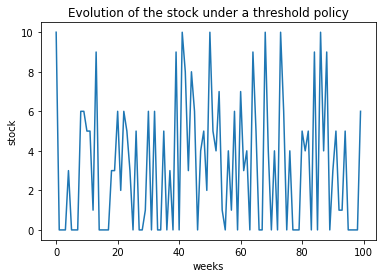

In [7]:
plt.figure()
plt.plot(States3[range(100)])
plt.xlabel('weeks')
plt.ylabel('stock')
plt.title('Evolution of the stock under a threshold policy')

# Dynamic Programming

Here we assume that we work on a *known* MDP: that is, we know the demand distribution hence we are able to compute the parameters of the MDP: the transition kernel and the average reward

## Computating the parameters of the MDP

Using the characteristics of the demand distributions, we are able to compute the expected rewards $r(s,a)$ and the transition probabilities $p(s'|s,a)$ for all states and actions. 

In [8]:
# MDP parameters
P = np.zeros((M+1,M+1,M+1)) # P[s,a,s'] = p(s' | s,a) 
r = np.zeros((M+1,M+1)) # r[s,a] = average reward received in state s when playing action a

## computation: iterate over all possible states, actions, and possible demand values
for a in range(M+1):
    for s in range(M+1):
        for d in range(M+1):
            # next state and reward with demand d
            ns = max(0,min(M,s+a) -d)
            reward = -c*a - h*s+p*min(M,d,s+a)
            if (a>0):
                reward = reward - c0
            P[s,a,ns] += pdem[d]
            r[s,a] += pdem[d] * reward

## Evaluation of deterministic policies

**Evalute a policy of your choice using Monte-Carlo simulation, i.e. compute the value of this policy in all states.** 

Observe that we do not need the knowledge of $P$ and $r$ for this method, we only need to be able to simulate trajectories.  

**Implement a function that evaluates a policy Pi using the matrix inversion technique seen in class. Compare the output with the previous method for the same policy.**

Unlike the previous evaluation method, this one requires the knowledge of $P$ and $r$. 

Evaluate two different policies and visualize their values for the different states in order to decide which one is better. 

## Computing the Optimal Policy

The function given below performs policy improvement, and may be useful to implement both value iteration and policy iteration. Note that the (deterministic) policy it outputs is encoded as a vector, not a function. 


In [9]:
# policy improvement
def Improve(V):
    '''computes the Q table associated to V and 
    return Pi=greedy(V)=greedy(Q) as well as max_{a} Q[s,a]'''
    Pi = np.zeros(M+1) # improved policy 
    newV = np.zeros(M+1)
    # compute the Q table 
    Q = np.zeros((M+1,M+1))
    for s in range(M+1):
        for a in range(M+1):
            Q[s,a]=r[s,a]+gamma*np.sum([P[s,a,ns]*V[ns] for ns in range(M+1)])
        # improvement (greedy policy wrt to Q)
        pi = np.argmax(Q[s,:])
        Pi[s]=pi
        newV[s]=Q[s,pi]
        Pi=Pi.astype(int)
    return Pi,newV


**Implement Value Iteration and Policy Iteration.**

First, check that the two algorithms output the same optimal policy. Then, you may compare the number of iteration needed by both algorithms as well as the executation time. 

Comment on the optimal policy that is obtained.  

## Q-Learning

In [23]:
def QLearning(Landmarks):
    star=time.time()
    nbLands = len(Landmarks)
    # random initialization of the Q table
    Q = 10*np.random.rand(1+M, 1+M) 
    N = np.zeros((M+1,M+1)) # number of visits to state-values 
    epsilon = 0.3
    s0 = np.random.randint(M+1)
    env=StoreManagement(s0)
    for k in range(nbLands-1):       
        for t in range(Landmarks[k]+1,Landmarks[k+1]):
            S=env.state
            A =np.random.randint(M+1)
            if (rd.random()>epsilon):# epsilon-greedy choice of action
                 A = np.argmax(Q[S, :]) # greedy action           
            N[S,A] += 1
            nS,rew,x,y = env.step(A)
            delta = rew + gamma * max(Q[nS, :]) - Q[S,A]
            alpha = 1/((1+N[S,A])**0.5)
            Q[S, A] += alpha * delta
        # compute the greedy policy 
        Pi = np.array([np.argmax(Q[s,:]) for s in range(M+1)])
        Pi = Pi.astype(int)
        print("After T=",Landmarks[k+1],"iterations (",np.floor(time.time()-start),"seconds), the policy is",Pi)
    return Pi,Q

Landmarks = np.array([0,10**3,10**4,10**5,10**6,10**7])
Pi,Q = QLearning(Landmarks)

# for T >= 10^7, we obtain correct policies
# for T >= 10^8, we almost obtain the right one

After T= 1000 iterations ( 159.0 seconds), the policy is [10  4  3 12 11  3  2  2 14  5  3  6  1  0 10  4]
After T= 10000 iterations ( 159.0 seconds), the policy is [8 6 4 7 0 2 1 0 0 2 0 3 1 0 4 1]
After T= 100000 iterations ( 162.0 seconds), the policy is [9 7 6 7 9 0 0 2 0 0 4 0 0 0 0 0]
After T= 1000000 iterations ( 188.0 seconds), the policy is [9 8 3 9 4 0 0 0 0 0 0 0 0 0 0 0]
After T= 10000000 iterations ( 436.0 seconds), the policy is [9 8 6 5 5 0 0 0 0 0 0 0 0 0 0 0]


Q-Learning is extremely slow to converge. In practice, as a retail store manager, you will obviously do something smarter. Leveraging your knowledge that the optimal policy will be a threshold policy, you could for example run a bandit strategy on a well chosen finite set of reasonnable thresholds. Or just refill the stock every week until you have a good estimate of the demand distribution and then compute the optimal policy for this estimated demand distribution.  